In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

In [4]:
target='transaction_real_price'
min_mem_size=6 
run_time=500

In [5]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [6]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:10000 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /Users/bonnie/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpecx_r09n
  JVM stdout: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpecx_r09n/h2o_bonnie_started_from_python.out
  JVM stderr: /var/folders/f1/2lb7b2n57j9d7ktf62rd4mkh0000gn/T/tmpecx_r09n/h2o_bonnie_started_from_python.err
  Server is running at http://127.0.0.1:10000
Connecting to H2O server at http://127.0.0.1:10000 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_bonnie_v132zi
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [7]:
# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv
df = h2o.import_file(path = 'data/trainPriceCleaned.csv')
#train["bad_loan"] = train["bad_loan"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,int,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,15150000.0,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,414823366.3143693,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,4240000000.0,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,334805341.89587265,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,0,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000.0,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000.0,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000.0,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [8]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [9]:
X=get_independent_variables(df, target) 
print(X)

['city', 'floor', 'total_parking_capacity_in_site', 'total_household_count_in_sites', 'apartment_building_count_in_sites', 'total_household_count_of_area_type', 'room_count', 'bathroom_count', 'heat_fuel_cogeneration', 'heat_fuel_gas', 'heat_type_central', 'heat_type_district', 'heat_type_individual', 'front_door_structure_corridor', 'front_door_structure_mixed', 'front_door_structure_stairway', 'exclusive_use_area', 'supply_area']


In [10]:
# Set target and predictor variables
y = target

In [10]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [11]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [12]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [13]:
meta_data

{'model_execution_time': {'regression': 437.59399700164795}}

In [14]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid_1_AutoML_20190412_012604_model_2,2.89392e+16,1.70115e+08,2.89392e+16,1.01231e+08,0.32973
GBM_1_AutoML_20190412_012604,2.96415e+16,1.72167e+08,2.96415e+16,1.04213e+08,0.339215
XGBoost_1_AutoML_20190412_012604,3.01684e+16,1.73691e+08,3.01684e+16,1.02293e+08,0.331826
XGBoost_grid_1_AutoML_20190412_012604_model_1,3.04741e+16,1.74568e+08,3.04741e+16,1.03589e+08,0.339529
XGBoost_grid_1_AutoML_20190412_012604_model_5,3.08888e+16,1.75752e+08,3.08888e+16,1.01943e+08,0.329915
GBM_grid_1_AutoML_20190412_012604_model_16,3.13089e+16,1.76943e+08,3.13089e+16,1.03779e+08,0.343121
GBM_grid_1_AutoML_20190412_012604_model_15,3.13727e+16,1.77123e+08,3.13727e+16,1.04722e+08,0.337649
GBM_3_AutoML_20190412_012604,3.14988e+16,1.77479e+08,3.14988e+16,1.05904e+08,0.341879
GBM_4_AutoML_20190412_012604,3.15711e+16,1.77682e+08,3.15711e+16,1.04068e+08,0.335661
XGBoost_2_AutoML_20190412_012604,3.16218e+16,1.77825e+08,3.16218e+16,1.02519e+08,0.334078


In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [16]:
best_model.algo

'xgboost'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

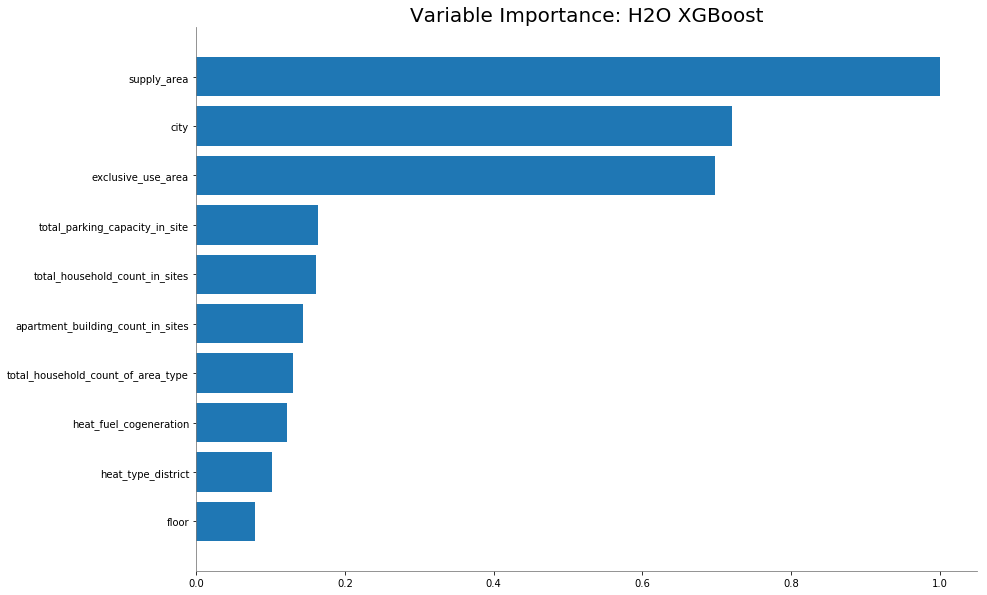

In [18]:
best_model.varimp_plot()

In [19]:
df[y] = df[y].asfactor()

In [20]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
# set auto

aml = H2OAutoML(max_runtime_secs=900, exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)
    
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}
print (meta_data)

print(aml.leaderboard)

AutoML progress: |████████████████████████████████████████████████████████| 100%
{'model_execution_time': {'regression': 770.712281703949}}


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190412_025147,2.83413e+16,1.68349e+08,2.83413e+16,1.02997e+08,0.336906
XGBoost_grid_1_AutoML_20190412_025147_model_1,2.84504e+16,1.68672e+08,2.84504e+16,1.00677e+08,0.32952
GBM_1_AutoML_20190412_030307,2.85147e+16,1.68863e+08,2.85147e+16,1.02924e+08,0.338887
XGBoost_grid_1_AutoML_20190412_025147_model_9,2.92906e+16,1.71145e+08,2.92906e+16,1.01065e+08,0.332222
XGBoost_grid_1_AutoML_20190412_030307_model_9,2.94858e+16,1.71714e+08,2.94858e+16,1.01579e+08,0.333928
XGBoost_grid_1_AutoML_20190412_030307_model_4,2.96623e+16,1.72228e+08,2.96623e+16,1.027e+08,0.339225
GBM_grid_1_AutoML_20190412_030307_model_16,2.97983e+16,1.72622e+08,2.97983e+16,1.0639e+08,0.351746
XGBoost_grid_1_AutoML_20190412_025147_model_11,2.99557e+16,1.73077e+08,2.99557e+16,1.0138e+08,0.333319
GBM_grid_1_AutoML_20190412_025147_model_30,3.00097e+16,1.73233e+08,3.00097e+16,1.05518e+08,0.34497
XGBoost_1_AutoML_20190412_025147,3.00426e+16,1.73328e+08,3.00426e+16,1.02117e+08,0.332696


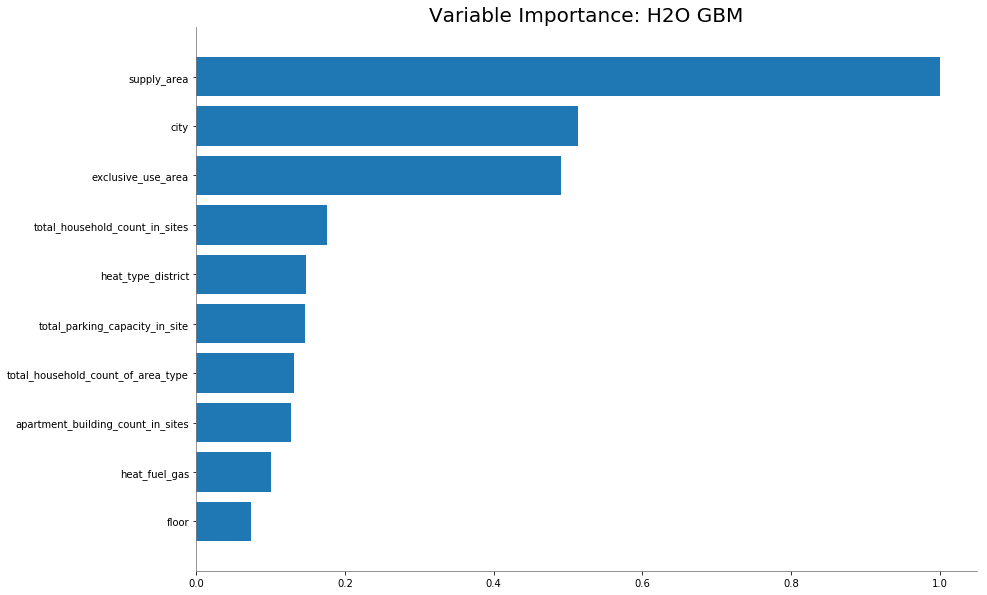

In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

best_model.varimp_plot()

In [16]:
params = best_model.params
print (params)
with open('800_data.json', 'w') as f:
    json.dump(params, f)
print ("done")

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_20190412_030307', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_20190412_030307'}}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'automl_training_trainPriceCleaned.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}}, 'validation_frame': {'default': None, 'actual': None}, 'nfolds': {'default': 0, 'actual': 5}, 'keep_cross_validation_models': {'default': True, 'actual': False}, 'keep_cross_validation_predictions': {'default': False, 'actual': True}, 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False}, 'score_each_iteration': {'default': False, 'actual': False}, 'score_tree_interval': {'default': 0, 'actual': 5}, 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},

In [11]:
aml = H2OAutoML(max_runtime_secs=700,
                exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [12]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}
meta_data

{'model_execution_time': {'regression': 647.3190739154816}}

In [13]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190412_025147,2.83413e+16,1.68349e+08,2.83413e+16,1.02997e+08,0.336906
XGBoost_grid_1_AutoML_20190412_025147_model_1,2.84504e+16,1.68672e+08,2.84504e+16,1.00677e+08,0.32952
XGBoost_grid_1_AutoML_20190412_025147_model_9,2.92906e+16,1.71145e+08,2.92906e+16,1.01065e+08,0.332222
XGBoost_grid_1_AutoML_20190412_025147_model_11,2.99557e+16,1.73077e+08,2.99557e+16,1.0138e+08,0.333319
GBM_grid_1_AutoML_20190412_025147_model_30,3.00097e+16,1.73233e+08,3.00097e+16,1.05518e+08,0.34497
XGBoost_1_AutoML_20190412_025147,3.00426e+16,1.73328e+08,3.00426e+16,1.02117e+08,0.332696
XGBoost_grid_1_AutoML_20190412_025147_model_7,3.00548e+16,1.73363e+08,3.00548e+16,1.03362e+08,0.338225
XGBoost_grid_1_AutoML_20190412_025147_model_5,3.024e+16,1.73896e+08,3.024e+16,1.021e+08,0.337123
GBM_grid_1_AutoML_20190412_025147_model_7,3.04094e+16,1.74383e+08,3.04094e+16,1.03236e+08,0.342389
XGBoost_grid_1_AutoML_20190412_025147_model_13,3.05504e+16,1.74787e+08,3.05504e+16,1.02342e+08,0.333941


In [18]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [19]:
best_model.algo

'xgboost'

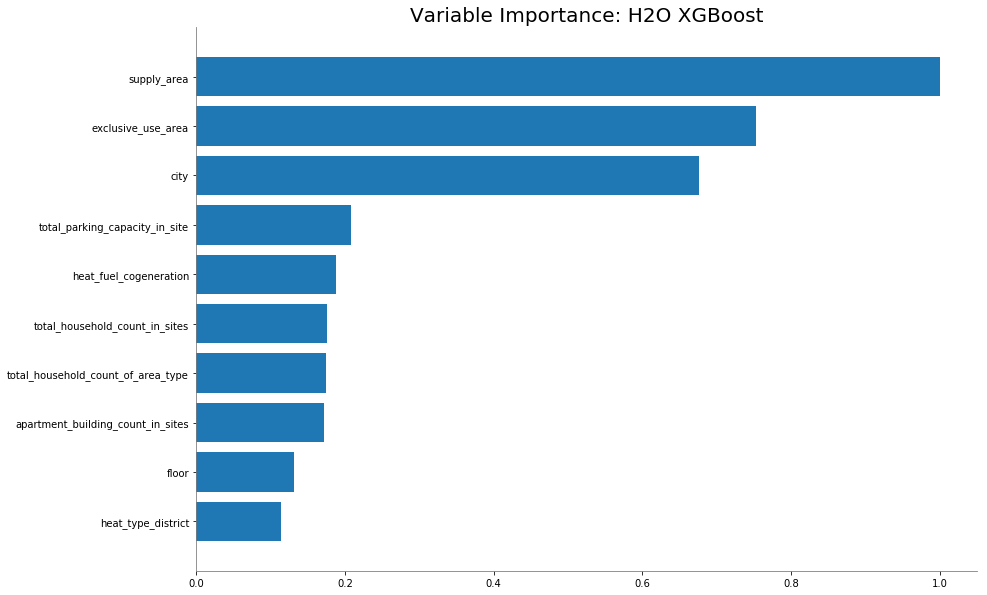

In [21]:
best_model.varimp_plot()

In [26]:
keys = best_model.params.keys()
keys

dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'distribution', 'tweedie_power', 'categorical_encoding', 'quiet_mode', 'export_checkpoints_dir', 'ntrees', 'max_depth', 'min_rows', 'min_child_weight', 'learn_rate', 'eta', 'sample_rate', 'subsample', 'col_sample_rate', 'colsample_bylevel', 'col_sample_rate_per_tree', 'colsample_bytree', 'max_abs_leafnode_pred', 'max_delta_step', 'monotone_constraints', 'score_tree_interval', 'min_split_improvement', 'gamma', 'nthread', 'max_bins', 'max_leaves', 'min_sum_hessian_in_leaf', 'min_data_in_leaf', 'sample_type', 'normalize_type', 'rate_drop', 'one_drop', 'skip_drop', 'tree_metho

In [37]:
params = best_model.params
params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XGBoost_grid_1_AutoML_20190412_012604_model_2',
   'type': 'Key<Model>',
   'URL': '/3/Models/XGBoost_grid_1_AutoML_20190412_012604_model_2'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_trainPriceCleaned.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_trainPriceCleaned.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'fold_assignment': {'default': 

In [38]:
with open('data.json', 'w') as f:
    json.dump(params, f)

In [22]:
df[y] = df[y].asfactor()

In [23]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [56]:
aml_1000 = H2OAutoML(max_runtime_secs=333,project_name = "project") # init automl, run for 300 seconds
aml_1000.train(x=X,  
           y=y,
           training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [57]:
leaderboard_1000 = aml_1000.leaderboard
leaderboard_1000.head(50)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190412_011235_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_005611_model_1,nan,nan,nan,nan


In [58]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=400,exclude_algos = ['DeepLearning'])

In [59]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [60]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [61]:
meta_data

{'model_execution_time': {'regression': 354.5295760631561}}

In [62]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_203300_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_211049_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_004249_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190412_011844_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_192454_model_1,nan,nan,nan,nan


In [21]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time)

In [22]:
model_start_time = time.time()
  
try:
    aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
    logging.critical('aml.train') 
    h2o.download_all_logs(dirname=logs_path, filename=logfile)      
    h2o.cluster().shutdown()   
    sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [26]:
d=meta_data['model_execution_time']
d['classification']=(time.time() - model_start_time)
meta_data['model_execution_time'] = d

In [27]:
meta_data

{'model_execution_time': {'regression': 303.90435099601746,
  'classification': 870.9414427280426}}

In [28]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan


In [41]:
target='transaction_real_price'
min_mem_size=6
run_time=333

In [42]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [43]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [44]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [45]:
meta_data

{'model_execution_time': {'regression': 298.1435778141022}}

In [46]:
print(aml.leaderboard)

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190411_180444_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_203300_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_211049_model_1,nan,nan,nan,nan
GLM_grid_1_AutoML_20190411_192454_model_1,nan,nan,nan,nan


In [15]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [16]:
best_model.algo

'xgboost'

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

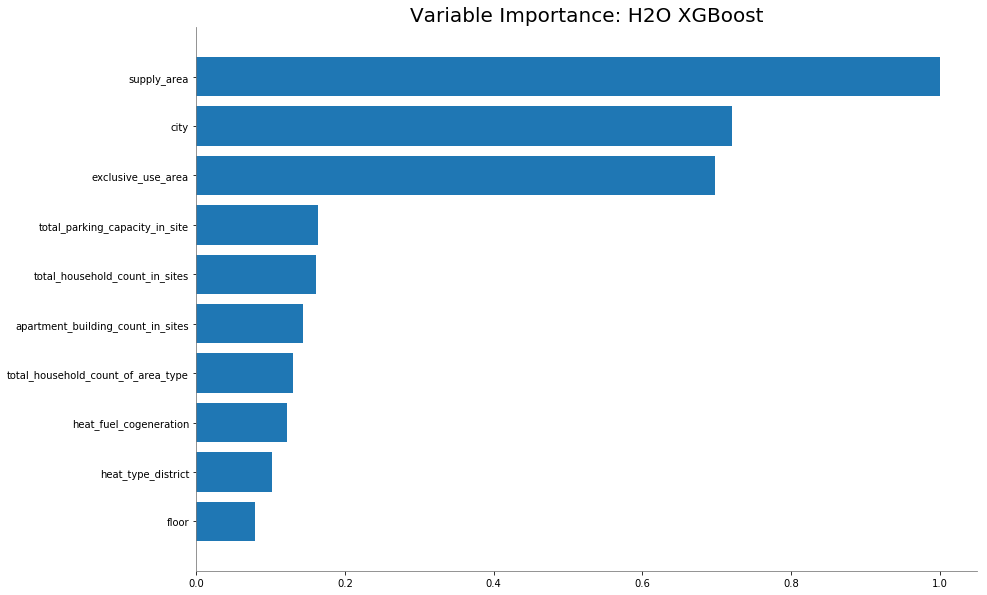

In [18]:
best_model.varimp_plot()

In [19]:
df[y] = df[y].asfactor()

In [20]:
df.describe()

Rows:4447
Cols:19




,transaction_real_price,city,exclusive_use_area,floor,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,supply_area,total_household_count_of_area_type,room_count,bathroom_count,heat_fuel_cogeneration,heat_fuel_gas,heat_type_central,heat_type_district,heat_type_individual,front_door_structure_corridor,front_door_structure_mixed,front_door_structure_stairway
type,enum,int,real,int,int,int,int,real,int,int,int,int,int,int,int,int,int,int,int
mins,,0.0,24.2475,1.0,0.0,100.0,1.0,33.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,,0.633235889363616,80.43324200584667,10.161457162131775,1320.9788621542616,1191.7533168428156,12.970991679784124,103.30118956599955,292.6532493816056,2.9759388351697784,1.597031706768608,0.2397121655048347,0.7602878344951652,0.08162806386327862,0.24061164830222623,0.6777602878344952,0.259051045648752,0.016865302451090622,0.7240836519001574
maxs,,1.0,266.8181,66.0,9766.0,6864.0,124.0,343.89,2960.0,6.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,,0.4819755547191596,28.772107257421734,7.028892141141552,1448.080749614069,1135.12591706417,14.331711124397955,33.90022505192435,329.45238690672653,0.6674127834544982,0.5081169355394869,0.4269557765991174,0.4269557765991174,0.27382801949303126,0.427502959168945,0.46738678111809034,0.43816295324580384,0.12878118423684082,0.4470251147192063
zeros,,1631,0,0,3,0,0,0,54,8,8,3381,1066,4084,3377,1433,3295,4372,1227
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,334000000,1.0,84.94,12.0,3481.0,2678.0,25.0,102.02,2254.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,400000000,1.0,114.88,17.0,1665.0,2017.0,22.0,137.59,325.0,4.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,290000000,0.0,84.96,7.0,1761.0,1326.0,9.0,109.77,209.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

meta_data

print(aml.leaderboard)

best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

best_model.algo

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

best_model.varimp_plot()

df[y] = df[y].asfactor()

df.describe()